In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem
import time

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
plt.style.use('science')
mpl.rcParams['text.usetex'] = False ## We do not have LaTex on stellar HPC...
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import jax.random as random 
from matplotlib.patches import Ellipse
import jax.scipy.stats as statsjax

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent, DirectAdjoint, RecursiveCheckpointAdjoint
import JaxCoords as jc
import JaxStreams_CustomForwardMode_MassRadiusImpact as JaxStreams #JaxStreams_EarlierVersion as JaxStreams#
from jax.scipy.stats import gaussian_kde
from jax.scipy.special import logsumexp
import agama
import Pal5Frame as P5frame
import diffrax
import matplotlib



/tmp/ipykernel_4013690/3183886119.py:21: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import sys, importlib
importlib.reload(JaxStreams)

gpu


<module 'JaxStreams_CustomForwardMode_MassRadiusImpact' from '/scratch/gpfs/jn5830/JaxStreamProject/JaxStreams_CustomForwardMode_MassRadiusImpact.py'>

In [3]:
jax.devices()

[cuda(id=0)]

In [4]:
from astropy.table import Table
table = Table.read('gd1_membership_likelhoods_init.ecsv', format='ascii.ecsv')


In [5]:
gd1_table = table[table['allstream (MLE)']>=0.75]
ra_rad, dec_rad = jnp.deg2rad(gd1_table['coord'].ra.value), jnp.deg2rad(gd1_table['coord'].dec.value)


In [6]:
@jax.jit
def icrs_to_gd1(ra_rad, dec_rad):
    R = jnp.array(
        [
            [-0.4776303088, -0.1738432154, 0.8611897727],
            [0.510844589, -0.8524449229, 0.111245042],
            [0.7147776536, 0.4930681392, 0.4959603976],
        ]
    )


    icrs_vec = jnp.vstack([jnp.cos(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(dec_rad)]).T

    stream_frame_vec = jnp.einsum('ij,kj->ki',R,icrs_vec)
    
    phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
    phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi

    
    return phi1, phi2

phi1, phi2 = icrs_to_gd1(ra_rad, dec_rad)

#phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
#phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi


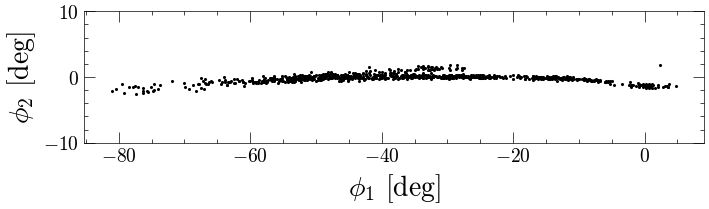

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(phi1, phi2,s=1.5,color='k')
    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [8]:
prog_bool = (phi1>-23) & (phi1<-19)
inside_coords = gd1_table[np.arange(len(gd1_table))[prog_bool]]


#gd1_table[prog_bool]

In [9]:
mean_ra, mean_dec = np.mean(inside_coords['coord'].ra),np.mean(inside_coords['coord'].dec)
mean_pmra_cosdec = np.mean(inside_coords['coord'].pm_ra_cosdec)
mean_pmdec = np.mean(inside_coords['coord'].pm_dec)
mean_dist = 7.85*u.kpc#8.5*u.kpc#8.2*u.kpc
mean_rv = -60*u.km/u.s#-60.0*u.km/u.s

In [10]:
from astropy.coordinates import SkyCoord, Galactocentric
galactic_coords = SkyCoord(ra=mean_ra, dec=mean_dec, 
                              distance=mean_dist, pm_ra_cosdec=mean_pmra_cosdec, 
                              pm_dec=mean_pmdec, radial_velocity=mean_rv, frame='icrs').transform_to(Galactocentric)

In [11]:
## Demonstrate icrs --> simcart (same as galactocentric)
inp = jnp.hstack([jnp.deg2rad(mean_ra),jnp.deg2rad(mean_dec),mean_dist])
print('internal:' + str(jc.alpha_delta_to_simcart(inp)))
print('galactocentric:'+ str([galactic_coords.x.value,galactic_coords.y.value,galactic_coords.z.value]))
## Demonstrate simcart --> icrs
simcart = jc.alpha_delta_to_simcart(inp)
print('internal:' + str(jc.simcart_to_icrs(simcart)))
print('init:' + str(jnp.hstack([mean_ra.value, mean_dec.value, mean_dist.value])))

## Demonstrate simcart pos,vel --> icrs
sim_qdot = jnp.hstack([galactic_coords.v_x.to(u.kpc/u.Myr),galactic_coords.v_y.to(u.kpc/u.Myr), galactic_coords.v_z.to(u.kpc/u.Myr)])
print('internal:' + str(jc.simvel_to_ICRS(simcart, sim_qdot)))
print('true:' + str([mean_pmra_cosdec,mean_pmdec,mean_rv.to(u.kpc/u.Myr)]))

internal:[-11.75634244   1.48502908   6.81848711]
galactocentric:[-11.75634244205854, 1.485029078163688, 6.818487110840469]
internal:(Array(166.55926149, dtype=float64), Array(49.52629511, dtype=float64), Array(7.85, dtype=float64))
init:[166.55926149  49.52629511   7.85      ]
internal:(Array(-7.26900552, dtype=float64), Array(-9.81494895, dtype=float64), Array(-0.06136273, dtype=float64))
true:[<Quantity -7.26900544 mas / yr>, <Quantity -9.81494891 mas / yr>, <Quantity -0.06136273 kpc / Myr>]


In [12]:
prog_xf = simcart #kpc
prog_vf = sim_qdot #kpc/Myr
prog_wf = jnp.hstack([prog_xf, prog_vf])



In [13]:
# heliocentric ICRS celestial coordinates and velocity of the LMC
# (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
# transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
# (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)
posvel_LMC = np.array(posvelLMC)
posvel_LMC[3:] = (posvel_LMC[3:]*u.km/u.s).to(u.kpc/u.Myr).value
posvel_LMC = jnp.array(posvel_LMC)

In [14]:
bar_pattern = ((-60.0*u.km/u.s)/u.kpc).to(1.0/u.Myr).value #in rad / Myr

params_global_potential = {'m_disk':5.0e10, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0, 'bar_m':0.5e10, 'bar_a':1.0, 'bar_b':1.0, 'bar_c':0.5, 'bar_Omega': bar_pattern}

pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                       b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

pot_Bar = JaxStreams.BarPotential(m=params_global_potential['bar_m'], a=params_global_potential['bar_a'],
                                 b=params_global_potential['bar_b'], c=params_global_potential['bar_c'],Omega=params_global_potential['bar_Omega'],units=usys)

t0 = 0
t1 = -3000
n_keep_orbit = 500
ts = jnp.linspace(t0, t1,n_keep_orbit)

## Combine potentials
potential_list = [pot_disk,pot_NFW]
ext_pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


LMC_backwards = ext_pot.orbit_integrator_run_notdense(posvel_LMC,0,t1,ts,None)[:-1,:]


LMC_internal = {'m_NFW':2e10, 'r_s_NFW':2.0, 'bar_m':1e7, 'bar_a':0.5, 'bar_b':0.1, 'bar_c':0.05, 'bar_Omega':0.04}
LMC_orbit = {'x':LMC_backwards[:,0], 'y':LMC_backwards[:,1],
            'z':LMC_backwards[:,2], 't': ts}
pot_LMC = JaxStreams.LMCPotential(LMC_internal=LMC_internal,LMC_orbit=LMC_orbit,units=usys)

potential_list = [pot_disk,pot_NFW,pot_Bar, pot_LMC]
ext_pot_with_LMC = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)




In [15]:
progenitor_backwards_with_LMC = ext_pot_with_LMC.orbit_integrator_run_notdense(prog_wf,0,t1,ts,None)[:-1,:]
progenitor_backwards =  ext_pot.orbit_integrator_run_notdense(prog_wf,0,t1,ts,None)[:-1,:]

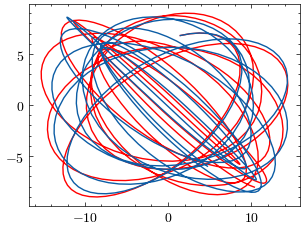

In [16]:
plt.plot(progenitor_backwards_with_LMC[:,1],progenitor_backwards_with_LMC[:,2],color='r')
plt.plot(progenitor_backwards[:,1],progenitor_backwards[:,2])

In [17]:
## Now generate unperturbed stream
seed_num = 4030
M_sat = .5e4 #progenitor mass
###t_strip_stop = -500#-500
t_strip = jnp.linspace(t1,t0,6_000) #10_000

start = time.time()
lead_arm, trail_arm = ext_pot_with_LMC.gen_stream_vmapped_notdense(t_strip, progenitor_backwards_with_LMC[-1], M_sat,seed_num,False)


end = time.time()
print(end-start)

smooth_stream_no_SH = jnp.vstack([lead_arm,trail_arm])[:,0,:]

57.43008041381836


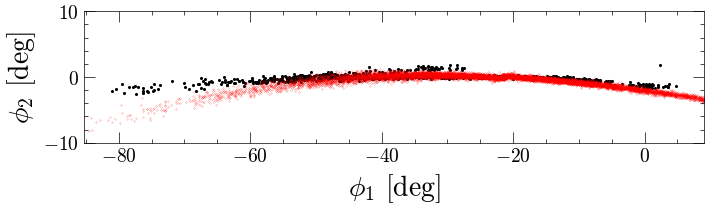

In [18]:
model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(smooth_stream_no_SH[:,:3])
phi1_smooth, phi2_smooth = icrs_to_gd1(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(phi1, phi2,s=1.5,color='k')
    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
xlim = ax.get_xlim()

ax.set_xlim(xlim)
ax.scatter(phi1_smooth, phi2_smooth,s=.02,color='r')

#ax.scatter(phi1_model_no_LMC, phi2_model_no_LMC,s=.02,color='cyan')
#ax.set_xlim(xlim[0],40)

ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

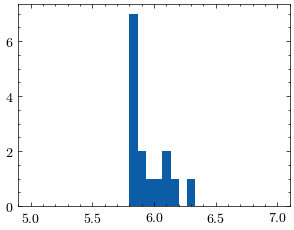

In [19]:
a0 = 3.26e-5 #1/Msun
beta = -1.9#-1.9
m0 = 2.52e7 #Msun
M_min = 10**5.8#
M_max = 5.0e7 #Msun
Nsamps = 150
# reference https://arxiv.org/pdf/2001.05503
@jax.jit
def dNdlogM(logM,a0,beta,m0):
    """
    log base 10!
    """
    return (a0/((m0**beta)*jnp.log(10.0)))*(10**(logM*(beta-1)))

@partial(jax.jit,static_argnums=(5,6))
def get_mass_samples(a0,beta,m0,M_min,M_max,Nsamps, seed):
    logM = jnp.linspace(jnp.log10(M_min),jnp.log10(M_max),2_000)
    dlogM = logM[2] - logM[1]
    prob_of_logM = dNdlogM(logM,a0,beta,m0) #this is a density
    #N_of_logM = jnp.cumsum(dNdlogM(logM,a0,beta,m0)*dlogM)
    #logM_of_N_spl = InterpolatedUnivariateSpline(N_of_logM,logM,k=3)
    key = random.PRNGKey(seed)
    mass_samples = random.choice(key=key,a=logM,shape=(Nsamps,),replace=True,p=prob_of_logM/prob_of_logM.sum())
    #unif = random.uniform(key=key,minval=N_of_logM.min(), maxval=N_of_logM.max(),shape=(Nsamps,))
    #mass_samples = logM_of_N_spl(unif)
    return mass_samples

Nsamps = 15
mass_samples = get_mass_samples(a0,beta,m0,M_min,M_max,Nsamps,3)
plt.hist(mass_samples,range=(5,7),bins=30);

In [20]:
@jax.jit
def get_particle_mean(stream, stream_phi1, phi1_0,phi1window=.1):
    phi1low, phi1high = phi1_0-phi1window, phi1_0+phi1window
    bool_in = (stream_phi1 > phi1low) & (stream_phi1 < phi1high)
    bool_in = bool_in.astype(int)
    stream_mean = jnp.sum(stream*bool_in[:,None], axis= 0)/jnp.sum(bool_in)                       
    return stream_mean
    
    
    
@jax.jit
def _get_subhalo_ImpactParams(particle_mean, tImpact, bImpact, alpha, beta, vImpact):
    """
    bImpact is radius in N-B plane
    alpha is inclination above TN plane (alpha = 0 is in TN plane)
    beta is azimuth in TN plane (alpha=0, beta = 0 is along T)
    """
    
    W0 = ext_pot_with_LMC.orbit_integrator_run_notdense(particle_mean,0,tImpact,None,False)[-1,:]
    T = W0[3:]
    T = T / jnp.sqrt(jnp.sum( T**2 ))
    B = jnp.cross(W0[:3],W0[3:])
    B = B / jnp.sqrt(jnp.sum( B**2 ))
    
    N = jnp.cross(B,T)
    
    X_I = W0[:3] + bImpact*( jnp.sin(alpha)*N + jnp.cos(alpha)*B )
    
    speed_stream = jnp.sqrt(jnp.sum(W0[3:]**2))
    vImpact = speed_stream - vImpact
    
    v_hat = jnp.cos(alpha)*jnp.cos(beta)*T + jnp.cos(alpha)*jnp.sin(beta)*N + jnp.sin(alpha)*B
    
    
    V_I = vImpact*v_hat#vImpact*( jnp.cos(alpha)*T + jnp.sin(alpha)*B)
    return jnp.hstack([X_I,V_I])

@jax.jit
def get_subhalo_ImpactParams(tImpact, bImpact, alpha, beta, vImpact,stream,stream_phi1,phi1_0,phi1window):
    particle_mean = get_particle_mean(stream, stream_phi1, phi1_0,phi1window=phi1window)
    ImpactW = _get_subhalo_ImpactParams(particle_mean,tImpact,bImpact,alpha,beta, vImpact)
    return ImpactW


phi1window = 0.05
ImpactFunc = lambda params: get_subhalo_ImpactParams(params[0],params[1],params[2],params[3],params[4],
                                                     smooth_stream_no_SH, phi1_smooth,
                                                     params[5], phi1window)

In [21]:
num_impacts = Nsamps #WAS 1000!!!
np.random.seed(54421) #54421
impact_times = jnp.array(np.random.uniform(-800,0,num_impacts))#-2500
impact_params = jnp.array(np.random.uniform(0.0,0.001,num_impacts)) #.01

alphas = jnp.deg2rad(jnp.array(np.random.uniform(-80,80,num_impacts)))
betas = jnp.deg2rad(jnp.array(np.random.uniform(0,359.9,num_impacts)))
vImpacts = jnp.array(np.random.uniform(-0.1,0.1,num_impacts))
phi0s = jnp.array(np.random.uniform(-50,0,num_impacts)) #-8,8

subhalo_masses = 10**mass_samples#10**jnp.array(np.random.uniform(5.,7.,num_impacts))#10**jnp.array(np.random.uniform(4.5,5.5,num_impacts))
subhalo_rs = jnp.array(np.random.uniform(0.01,0.2,num_impacts))#*0 + 0.02#jnp.array(np.random.uniform(0.020,0.08,num_impacts))





## Package
params_all = jnp.vstack([impact_times, impact_params, alphas, betas, vImpacts, phi0s]).T
SH_W0s = jnp.zeros((len(params_all),6))

SH_W0s = jax.vmap(ImpactFunc)(params_all)


#############subhalo_masses = 10**jnp.array(np.random.uniform(4.,5.,num_impacts))

subhalo_masses = subhalo_masses/1
subhalo_params = {'mass':subhalo_masses*1.0,'rs':subhalo_rs,'w0':SH_W0s,'t_impact':impact_times,
                  't_window':jnp.ones_like(subhalo_masses)*250}


In [22]:
np.log10(subhalo_masses)

array([6.13628583, 5.81804924, 5.80189992, 6.10778703, 5.81519936,
       5.82754884, 5.80379984, 5.81804924, 5.847498  , 6.10493715,
       5.87314692, 6.03179024, 5.94059408, 5.91304524, 6.27023019])

In [23]:
# Generate nonlinear perturbed stream with only a SINGLE impact
def gen_perturbed_stream():
 
    # setup subhalo potential
    pot_line_SH = JaxStreams.SubhaloLinePotential(m=subhalo_params['mass'],a=subhalo_params['rs'],
                                                  subhalo_x0=subhalo_params['w0'][:,:3],
                                                  subhalo_v = subhalo_params['w0'][:,3:], 
                                                  subhalo_t0=subhalo_params['t_impact'], t_window=subhalo_params['t_window'],units=usys)
    pot_list = [ext_pot_with_LMC, pot_line_SH]
    pot_total = JaxStreams.Potential_Combine(potential_list=pot_list,units=usys)
    progenitor_backwards =  pot_total.orbit_integrator_run_notdense(prog_wf,0,t1,None,False)[0]
    lead_arm, trail_arm = pot_total.gen_stream_vmapped_notdense(t_strip, progenitor_backwards, M_sat,seed_num,False)
    return jnp.vstack([lead_arm[:,0,:],trail_arm[:,0,:]])

    

In [24]:
non_lin_stream = gen_perturbed_stream()

In [25]:
@jax.jit
def release_func(prog_loc,M_sat, stripping_num, t,seed_num):
    """ 
    prog_loc is in phasespace. A 6dim progenitor phase space location
    """
    pos_close_new, pos_far_new, vel_close_new, vel_far_new  = ext_pot_with_LMC.release_model(prog_loc[:3], prog_loc[3:6], M_sat, stripping_num, t, seed_num)
    return jnp.vstack([jnp.hstack([pos_close_new,vel_close_new]),
                       jnp.hstack([pos_far_new, vel_far_new])])

mapped_release = jax.jit(jax.vmap(release_func,in_axes=((0,None,0,0,None))))
mapped_release_jacobian = jax.jit(jax.vmap(jax.jacfwd(release_func),in_axes=((0,None,0,0,None))))


In [26]:
## Set and run intilization
## This is independent of perturbations
    
#jnp.hstack([wf, jnp.zeros_like(wf)]), jnp.zeros_like(wf) ]

particle_nums = jnp.arange(0,len(t_strip))
flipped_particle_ids = jnp.flip(particle_nums)
particle_nums_stacked = jnp.hstack([particle_nums,particle_nums])

flipped_times = jnp.flip(t_strip)
t0s = jnp.hstack([flipped_times, flipped_times])
lead_trail_bool = jnp.hstack([ jnp.ones(len(t_strip)).astype(int), jnp.zeros_like(t_strip).astype(int) ])
lead_trail_bool = lead_trail_bool.astype(bool)


# Compute/save progenitor orbit, unperturbed 
prog_orbit =  ext_pot_with_LMC.orbit_integrator_run_notdense(prog_wf,0,t1,flipped_times,False)
particle_ICs_realspace = mapped_release(prog_orbit[:-1,:], M_sat, flipped_particle_ids,
               flipped_times, seed_num)

# Derivative of release function with respect to progenitor orbit (unperturbed)
dRel_dIC = mapped_release_jacobian(prog_orbit[:-1,:], M_sat, flipped_particle_ids,
                   flipped_times, seed_num)
    

# Generate/save unperturbed stream orbits
mapped_orb_generator = jax.vmap(ext_pot_with_LMC.orbit_integrator_run_dense,in_axes=((0,0,None,None,None)))
stream_func_lead = mapped_orb_generator(particle_ICs_realspace[:,0,:],jnp.flip(t_strip),0,None,None)
stream_func_trail = mapped_orb_generator(particle_ICs_realspace[:,1,:],jnp.flip(t_strip),0,None,None)

# Package and save states
#states = (stream_func_lead,stream_func_trail, t_strip)


In [27]:
subhalo_params['rs']

Array([0.11870031, 0.03535134, 0.19514437, 0.10641167, 0.13326948,
       0.01896823, 0.04602417, 0.10642693, 0.021604  , 0.10285252,
       0.13435478, 0.1829883 , 0.04684201, 0.17990641, 0.16054235],      dtype=float64)

In [28]:
subhalo_params['rs']*.95

Array([0.11276529, 0.03358378, 0.18538715, 0.10109108, 0.12660601,
       0.01801981, 0.04372296, 0.10110558, 0.0205238 , 0.09770989,
       0.12763704, 0.17383888, 0.04449991, 0.17091109, 0.15251524],      dtype=float64)

In [29]:
wf_and_deriv = [prog_wf,
                jnp.zeros((num_impacts,12))]


pot_line_SH = JaxStreams.SubhaloLinePotential(m=subhalo_params['mass']*0.0 + 1.0,a=subhalo_params['rs']*.5, #.5
                                                  subhalo_x0=subhalo_params['w0'][:,:3],
                                                  subhalo_v = subhalo_params['w0'][:,3:], 
                                                  subhalo_t0=subhalo_params['t_impact'], t_window=subhalo_params['t_window'],units=usys)
    
# setup subhalo radius potential
# This is the scale-radius derivative of the above subhalo potential
# Gives a new class of potential functions (R3 --> R) that we can use to solve ODEs
pot_line_SH_r = JaxStreams.SubhaloLinePotential_Radius(m=subhalo_params['mass']*0.0 + 1.0,a=subhalo_params['rs']*.5, #.5
                                                  subhalo_x0=subhalo_params['w0'][:,:3],
                                                  subhalo_v = subhalo_params['w0'][:,3:], 
                                                  subhalo_t0=subhalo_params['t_impact'], t_window=subhalo_params['t_window'],units=usys)
    
    
# Instantiate the base and pertubration potential
pot_total = JaxStreams.PotentialBase_and_PotentialPerturbation_and_PotentialStructural(potential_base=ext_pot_with_LMC,
                                                                                           potential_perturbation=pot_line_SH,
                                                                                           potential_structural=pot_line_SH_r,
                                                                                           units=usys)
    
    
# Integrate the progenitor (and its epsilon deriv) back from the current location. Save at the stripping times
prog_back_and_deriv_dense = pot_total.orbit_integrator_run_and_deriv_noPreComp_mass_radius(wf_and_deriv,0,t1,jnp.flip(t_strip),False)


##############
deriv_IC_lead_eps = jnp.einsum('ijk,ilk->ilj',dRel_dIC[:,0,:,:],prog_back_and_deriv_dense.ys[1][:-1,:,:6]) # this is 6: since we only want the derivs!
deriv_IC_trail_eps = jnp.einsum('ijk,ilk->ilj',dRel_dIC[:,1,:,:],prog_back_and_deriv_dense.ys[1][:-1,:,:6]) # First 6 is regular pos and vel
    
deriv_IC_lead_eps_r = jnp.einsum('ijk,ilk->ilj',dRel_dIC[:,0,:,:],prog_back_and_deriv_dense.ys[1][:-1,:,6:]) # index [1] is radius derivs, length 6
deriv_IC_trail_eps_r = jnp.einsum('ijk,ilk->ilj',dRel_dIC[:,1,:,:],prog_back_and_deriv_dense.ys[1][:-1,:,6:])


deriv_ICs_eps = jnp.vstack([deriv_IC_lead_eps,deriv_IC_trail_eps])
deriv_ICs_eps_r = jnp.vstack([deriv_IC_lead_eps_r,deriv_IC_trail_eps_r])
deriv_ICs = jnp.dstack([deriv_ICs_eps,deriv_ICs_eps_r]) #Nstar x NSH x 12


In [30]:
jax.jacfwd(pot_total.gradientPotentialPerturbation_per_SH)(jnp.array([1,2.,3.]),-30.0).shape

(15, 3, 3)

In [31]:
deriv_ICs_lead = jnp.dstack([deriv_IC_lead_eps,deriv_IC_lead_eps_r])
deriv_ICs_trail = jnp.dstack([deriv_IC_trail_eps,deriv_IC_trail_eps_r])

In [32]:
@jax.jit
def gen_single_deriv(star_ind):  
    ICs = deriv_ICs_lead[star_ind,:,:]
    state = (star_ind, stream_func_lead)
    lead_derivs = pot_total.orbit_integrator_run_StreamSpline_PID_mass_radius_SingleStar(ICs,flipped_times[star_ind],0.0,None,state).ys[0,:,:]
    
    
    ICs = deriv_ICs_trail[star_ind,:,:]
    state = (star_ind, stream_func_trail)
    trail_derivs = pot_total.orbit_integrator_run_StreamSpline_PID_mass_radius_SingleStar(ICs,flipped_times[star_ind],0.0,None,state).ys[0,:,:]
    
    return jnp.stack([lead_derivs,trail_derivs])
    #return lead_derivs, trail_derivs
    
@jax.jit
def gen_stream_deriv(inds):
    vmapped_func = jax.vmap(gen_single_deriv)
    return vmapped_func(inds)
    
    

In [33]:
inds = jnp.arange(len(t_strip))
derivs_single = gen_stream_deriv(inds)

In [34]:
dw_deps = jnp.vstack([derivs_single[:,0,:,:], derivs_single[:,1,:,:]])
dw_deps = jnp.swapaxes(dw_deps,0,1)#[:,:,:6]


In [35]:
dw_deps.shape

(15, 12000, 12)

In [36]:
"""
inds = jnp.arange(len(t_strip)).reshape(2,int(len(t_strip)/2))
s = time.time()
derivs_batch = jax.pmap(gen_stream_deriv)(inds)
e = time.time() 
print(e-s)

"""

'\ninds = jnp.arange(len(t_strip)).reshape(2,int(len(t_strip)/2))\ns = time.time()\nderivs_batch = jax.pmap(gen_stream_deriv)(inds)\ne = time.time() \nprint(e-s)\n\n'

In [37]:
"""
dw_deps = jnp.vstack([derivs_batch[0,:,:,:,:],derivs_batch[1,:,:,:,:]])

dw_deps = jnp.vstack([dw_deps[:,0,:,:], dw_deps[:,1,:,:]])#[:,:,:6]
dw_deps = jnp.swapaxes(dw_deps,0,1)[:,:,:6]
"""

'\ndw_deps = jnp.vstack([derivs_batch[0,:,:,:,:],derivs_batch[1,:,:,:,:]])\n\ndw_deps = jnp.vstack([dw_deps[:,0,:,:], dw_deps[:,1,:,:]])#[:,:,:6]\ndw_deps = jnp.swapaxes(dw_deps,0,1)[:,:,:6]\n'

In [36]:

l, t = jax.vmap(lambda s: s.evaluate(0.0))(stream_func_lead), jax.vmap(lambda s: s.evaluate(0.0))(stream_func_trail)
stream_unpert = jnp.vstack([l,t])#[jnp.flip(l,axis=0),jnp.flip(t,axis=0)]) 

In [37]:
"""
## Now generate unperturbed stream
seed_num = 4030
M_sat = .5e4 #progenitor mass
###t_strip_stop = -500#-500
t_strip = jnp.linspace(t1,t0,6_000) #10_000

start = time.time()
lead_arm, trail_arm = ext_pot_with_LMC.gen_stream_vmapped_notdense(t_strip, progenitor_backwards_with_LMC[-1], M_sat,seed_num,False)


end = time.time()
print(end-start)

smooth_stream_no_SH_flip = jnp.vstack([jnp.flip(lead_arm,axis=0),jnp.flip(trail_arm,axis=0)])[:,0,:]
"""

'\n## Now generate unperturbed stream\nseed_num = 4030\nM_sat = .5e4 #progenitor mass\n###t_strip_stop = -500#-500\nt_strip = jnp.linspace(t1,t0,6_000) #10_000\n\nstart = time.time()\nlead_arm, trail_arm = ext_pot_with_LMC.gen_stream_vmapped_notdense(t_strip, progenitor_backwards_with_LMC[-1], M_sat,seed_num,False)\n\n\nend = time.time()\nprint(end-start)\n\nsmooth_stream_no_SH_flip = jnp.vstack([jnp.flip(lead_arm,axis=0),jnp.flip(trail_arm,axis=0)])[:,0,:]\n'

In [37]:
dw_deps.shape

(15, 12000, 12)

In [38]:
delta_rs = subhalo_params['rs'] - subhalo_params['rs']*.5#.5

In [39]:
print(delta_rs)

[0.05935015 0.01767567 0.09757219 0.05320583 0.06663474 0.00948411
 0.02301209 0.05321346 0.010802   0.05142626 0.06717739 0.09149415
 0.02342101 0.0899532  0.08027118]


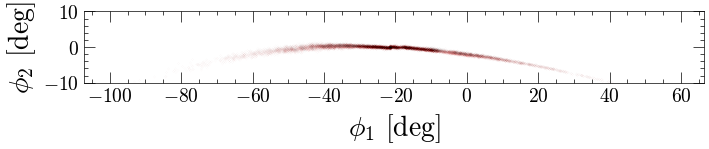

In [40]:
dw_deps_massSum = jnp.sum(subhalo_params['mass'][:,None,None]*dw_deps[:,:,:6] + 
                             subhalo_params['mass'][:,None,None]*delta_rs[:,None,None]*dw_deps[:,:,6:] ,axis=0)
stream_lin = stream_unpert + dw_deps_massSum

model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(stream_lin[:,:3])
phi1_lin, phi2_lin = icrs_to_gd1(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))


model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(non_lin_stream[:,:3])
phi1_nonlin, phi2_nonlin = icrs_to_gd1(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))


model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(stream_unpert[:,:3])
phi1_unpert, phi2_unpert = icrs_to_gd1(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
#ax.scatter(phi1, phi2,s=1.5,color='k')
    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)

ax.scatter(phi1_lin, phi2_lin,s=.00002,color='r')
ax.scatter(phi1_nonlin, phi2_nonlin,s=.00002,color='k')

#ax.scatter(phi1_model_no_LMC, phi2_model_no_LMC,s=.02,color='cyan')
#ax.set_xlim(xlim[0],40)

ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [41]:
np.log10(subhalo_masses)

array([6.13628583, 5.81804924, 5.80189992, 6.10778703, 5.81519936,
       5.82754884, 5.80379984, 5.81804924, 5.847498  , 6.10493715,
       5.87314692, 6.03179024, 5.94059408, 5.91304524, 6.27023019])

In [42]:
delta_non_lin = non_lin_stream - smooth_stream_no_SH
delta_lin = stream_lin - stream_unpert#smooth_stream_no_SH_flip

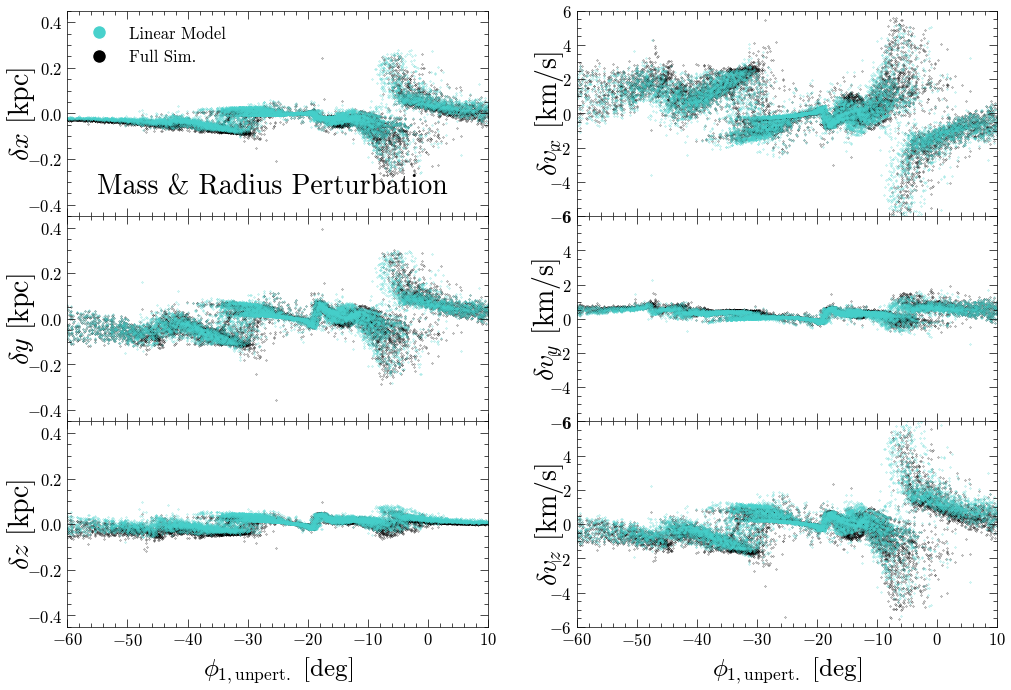

In [43]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12,8)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.05
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.21)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)


ax[0,0].text(-55,-0.35,'Mass & Radius Perturbation',fontsize=20)
fig.align_ylabels()

###plt.savefig('MassandRadiusPert_CorrectDensity.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


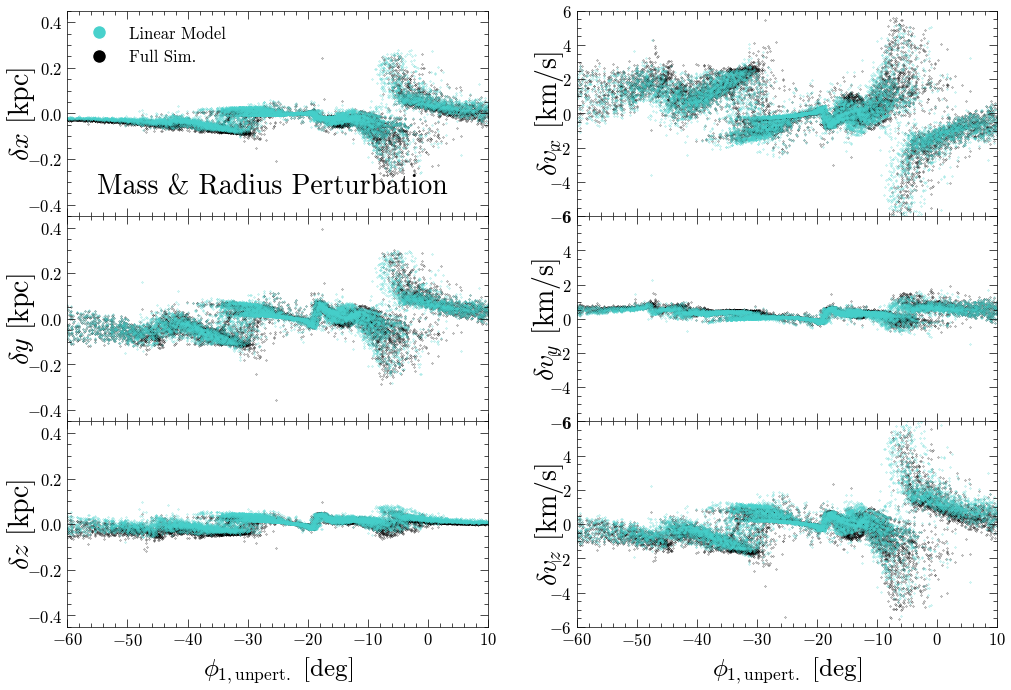

In [68]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12,8)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.05
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.21)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)


ax[0,0].text(-55,-0.35,'Mass & Radius Perturbation',fontsize=20)
fig.align_ylabels()

###plt.savefig('MassandRadiusPert_CorrectDensity.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


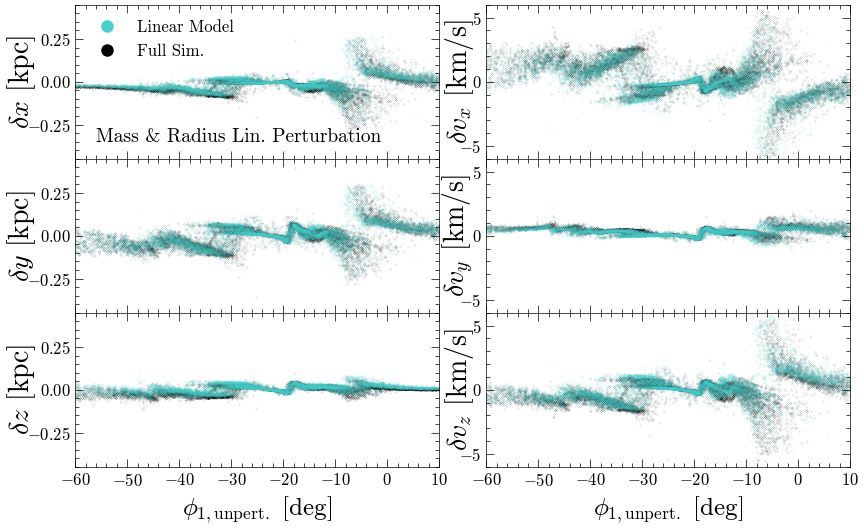

In [91]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10,6)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.005
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.13)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)


ax[0,0].text(-56,-0.35,'Mass & Radius Lin. Perturbation',fontsize=14)
fig.align_ylabels()

#####plt.savefig('MassandRadiusPert_CorrectDensity_15Major.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


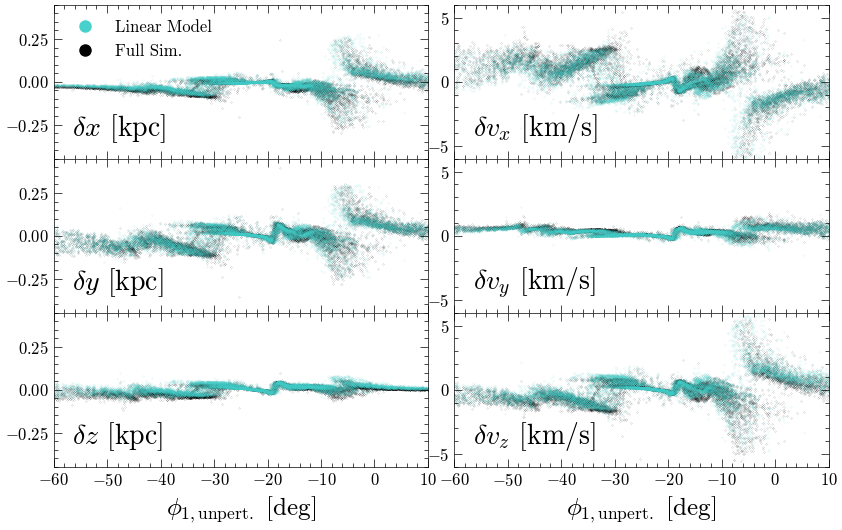

In [111]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10,6)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.005
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.07)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].text(0.05,0.15,r'$\delta x$ [kpc]',fontsize=20,transform=ax[0,0].transAxes)
ax[1,0].text(0.05,0.15,r'$\delta y$ [kpc]',fontsize=20,transform=ax[1,0].transAxes)
ax[2,0].text(0.05,0.15,r'$\delta z$ [kpc]',fontsize=20,transform=ax[2,0].transAxes)

ax[0,1].text(0.05,0.15,r'$\delta v_x$ [km/s]',fontsize=20,transform=ax[0,1].transAxes)
ax[1,1].text(0.05,0.15,r'$\delta v_y$ [km/s]',fontsize=20,transform=ax[1,1].transAxes)
ax[2,1].text(0.05,0.15,r'$\delta v_z$ [km/s]',fontsize=20,transform=ax[2,1].transAxes)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)


###ax[0,0].text(-56,-0.35,'Mass & Radius Lin. Perturbation',fontsize=14)
fig.align_ylabels()

###plt.savefig('MassandRadiusPert_CorrectDensity_15Major.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


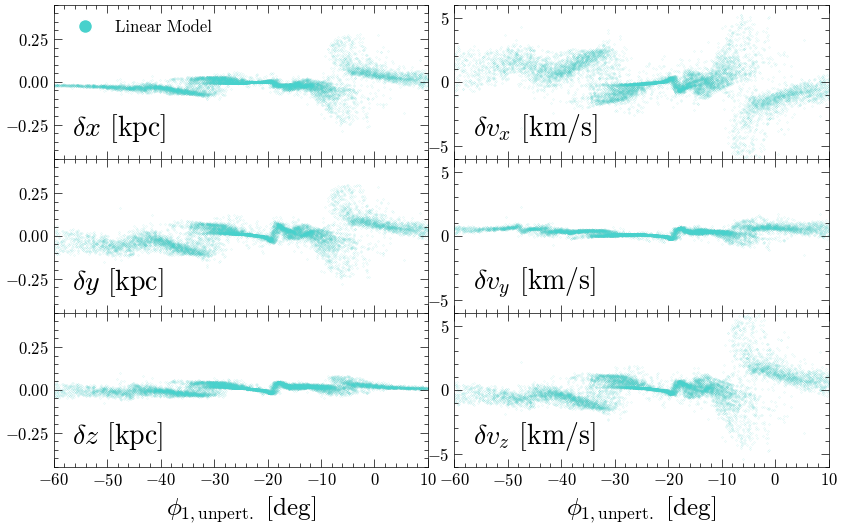

In [113]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10,6)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.005
#ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
#ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

#ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

#ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.07)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].text(0.05,0.15,r'$\delta x$ [kpc]',fontsize=20,transform=ax[0,0].transAxes)
ax[1,0].text(0.05,0.15,r'$\delta y$ [kpc]',fontsize=20,transform=ax[1,0].transAxes)
ax[2,0].text(0.05,0.15,r'$\delta z$ [kpc]',fontsize=20,transform=ax[2,0].transAxes)

ax[0,1].text(0.05,0.15,r'$\delta v_x$ [km/s]',fontsize=20,transform=ax[0,1].transAxes)
ax[1,1].text(0.05,0.15,r'$\delta v_y$ [km/s]',fontsize=20,transform=ax[1,1].transAxes)
ax[2,1].text(0.05,0.15,r'$\delta v_z$ [km/s]',fontsize=20,transform=ax[2,1].transAxes)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),]
                   #plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model'], loc='upper left', fontsize=12)


###ax[0,0].text(-56,-0.35,'Mass & Radius Lin. Perturbation',fontsize=14)
fig.align_ylabels()

###plt.savefig('MassandRadiusPert_CorrectDensity_15Major_LinModelOnly.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


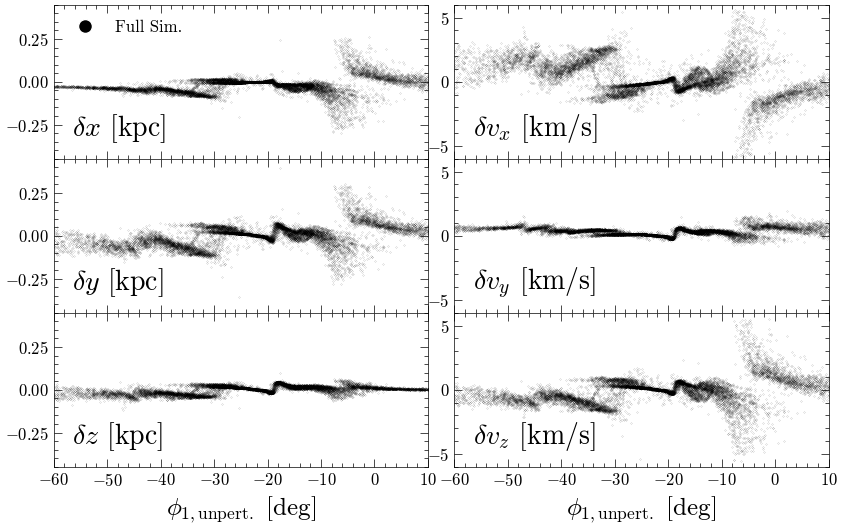

In [115]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10,6)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.005
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
#ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
#ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
#ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
#ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
#ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
#ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.07)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].text(0.05,0.15,r'$\delta x$ [kpc]',fontsize=20,transform=ax[0,0].transAxes)
ax[1,0].text(0.05,0.15,r'$\delta y$ [kpc]',fontsize=20,transform=ax[1,0].transAxes)
ax[2,0].text(0.05,0.15,r'$\delta z$ [kpc]',fontsize=20,transform=ax[2,0].transAxes)

ax[0,1].text(0.05,0.15,r'$\delta v_x$ [km/s]',fontsize=20,transform=ax[0,1].transAxes)
ax[1,1].text(0.05,0.15,r'$\delta v_y$ [km/s]',fontsize=20,transform=ax[1,1].transAxes)
ax[2,1].text(0.05,0.15,r'$\delta v_z$ [km/s]',fontsize=20,transform=ax[2,1].transAxes)


# Legend in top-left plot
legend_elements = [#plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Full Sim.'], loc='upper left', fontsize=12)


###ax[0,0].text(-56,-0.35,'Mass & Radius Lin. Perturbation',fontsize=14)
fig.align_ylabels()

###plt.savefig('MassandRadiusPert_CorrectDensity_15MajorFullSimOnly.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


In [60]:
dw_deps_massSum = jnp.sum(subhalo_params['mass'][:,None,None]*dw_deps[:,:,:6]*1.0 + 
                             subhalo_params['mass'][:,None,None]*delta_rs[:,None,None]*dw_deps[:,:,6:]*0 ,axis=0)
stream_lin = stream_unpert + dw_deps_massSum


delta_non_lin = non_lin_stream - smooth_stream_no_SH
delta_lin = stream_lin - stream_unpert

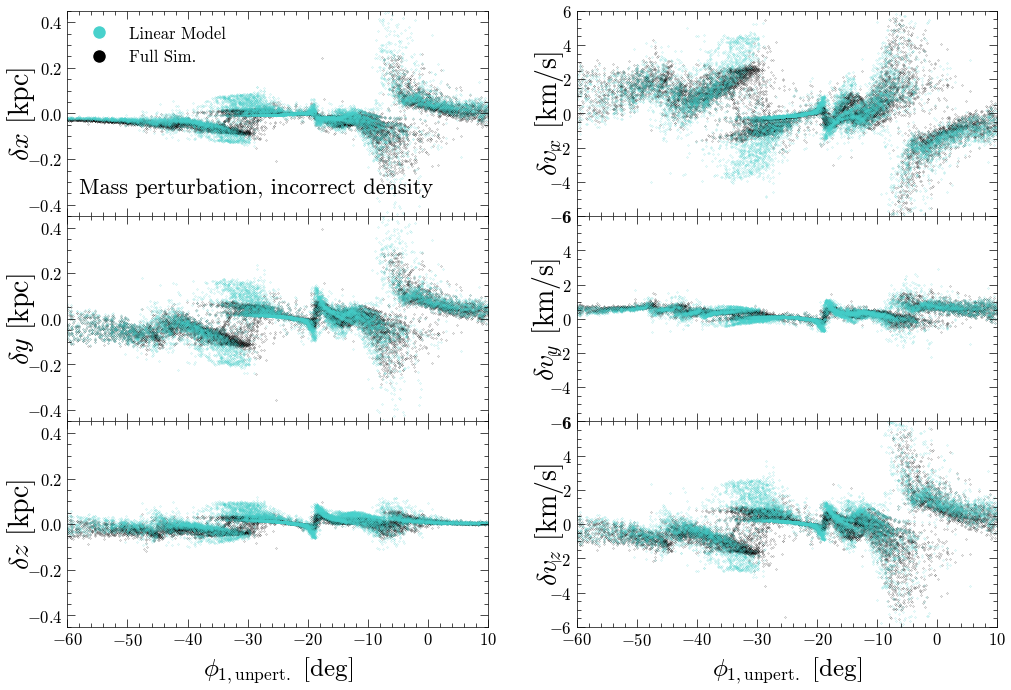

In [63]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12,8)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.02
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.45,.45)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.21)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)


ax[0,0].text(-58,-0.35,'Mass perturbation, incorrect density',fontsize=16)
fig.align_ylabels()

##plt.savefig('MassandRadiusPert_WrongDensity.pdf')

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


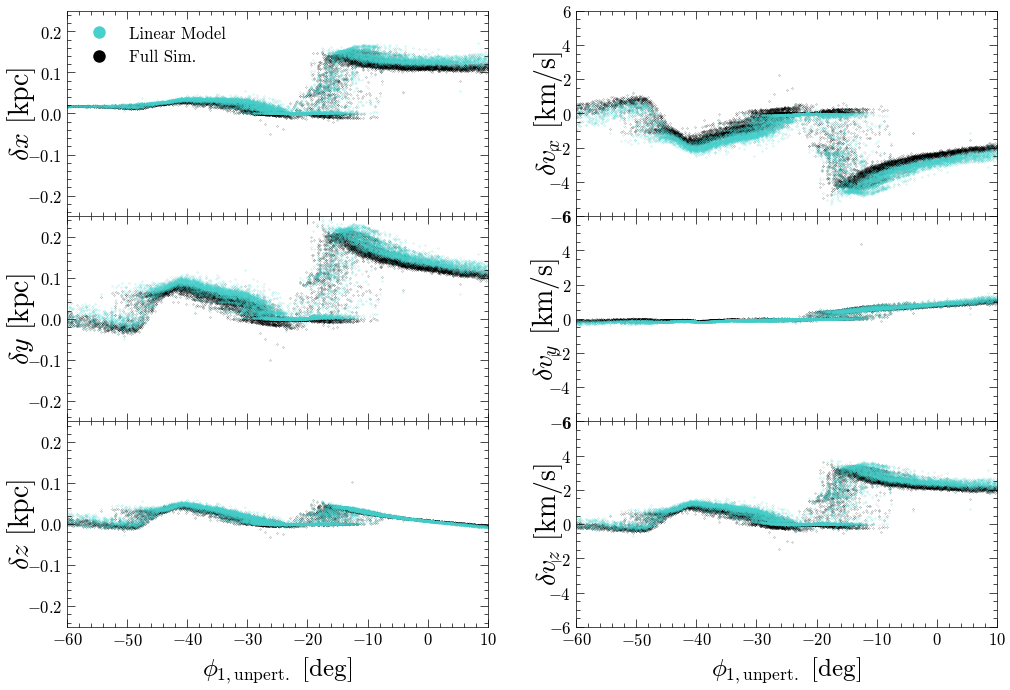

In [47]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12,8)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.02
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.25,.25)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-6,6)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.21)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)

fig.align_ylabels()

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


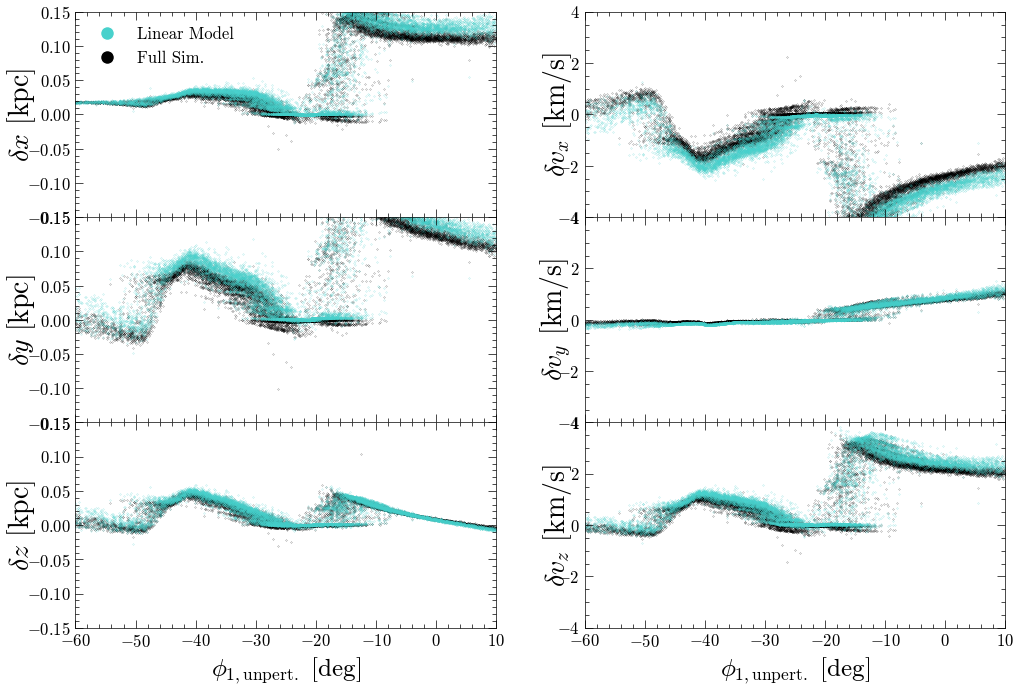

In [44]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(12,8)
kpcMyr_to_kms = (1*u.kpc/u.Myr).to(u.km/u.s)
s=0.02
ax[0,0].scatter(phi1_smooth,delta_non_lin[:,0],s=s,color='k',rasterized=True)
ax[0,0].scatter(phi1_unpert,delta_lin[:,0],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[1,0].scatter(phi1_smooth,delta_non_lin[:,1],s=s,color='k',rasterized=True)
ax[1,0].scatter(phi1_unpert,delta_lin[:,1],s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[2,0].scatter(phi1_smooth,delta_non_lin[:,2],s=s,color='k',rasterized=True)
ax[2,0].scatter(phi1_unpert,delta_lin[:,2],s=s,color='mediumturquoise',rasterized=True,alpha=1)


#####
ax[0,1].scatter(phi1_smooth,delta_non_lin[:,3]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[0,1].scatter(phi1_unpert,delta_lin[:,3]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[1,1].scatter(phi1_smooth,delta_non_lin[:,4]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[1,1].scatter(phi1_unpert,delta_lin[:,4]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)

ax[2,1].scatter(phi1_smooth,delta_non_lin[:,5]*kpcMyr_to_kms,s=s,color='k',rasterized=True)
ax[2,1].scatter(phi1_unpert,delta_lin[:,5]*kpcMyr_to_kms,s=s,color='mediumturquoise',rasterized=True,alpha=1)


ax[0,0].set_xlim(-60,10)
ax[0,0].set_ylim(-.15,.15)
for i in range(1,3):
    ax[i,0].set_xlim(ax[0,0].get_xlim())
    ax[i,0].set_ylim(ax[0,0].get_ylim())
    


#ax[1,0].set_xlim(-60,10)
#ax[1,0].set_ylim(-2,2)
#ax[2,0].set_xlim(-60,10)
#ax[2,0].set_ylim(-2,2)

ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_ylim(-4,4)
for i in range(1,3):
    ax[i,1].set_xlim(ax[0,0].get_xlim())
    ax[i,1].set_ylim(ax[0,1].get_ylim())
    



for i in range(2):
    ax[i,0].set_xticklabels([])
    ax[i,1].set_xticklabels([])

    
    
for i in range(3):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=12., length=6)
        ax[i, j].tick_params(axis='both', which='minor', length=3)
        

fig.subplots_adjust(hspace=0,wspace=.21)

ax[-1,0].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)
ax[-1,1].set_xlabel(r'$\phi_{1, \rm{unpert.}}$ [deg]',fontsize=18)

ax[0,0].set_ylabel(r'$\delta x$ [kpc]',fontsize=20,labelpad=-8)
ax[1,0].set_ylabel(r'$\delta y$ [kpc]',fontsize=20,labelpad=-8)
ax[2,0].set_ylabel(r'$\delta z$ [kpc]',fontsize=20,labelpad=-8)

ax[0,1].set_ylabel(r'$\delta v_x$ [km/s]',fontsize=20,labelpad=-12)
ax[1,1].set_ylabel(r'$\delta v_y$ [km/s]',fontsize=20,labelpad=-12)
ax[2,1].set_ylabel(r'$\delta v_z$ [km/s]',fontsize=20,labelpad=-12)


# Legend in top-left plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='mediumturquoise'),
                   plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='black')]
ax[0, 0].legend(legend_elements, ['Linear Model', 'Full Sim.'], loc='upper left', fontsize=12)

fig.align_ylabels()

##plt.savefig('10ImpactGD1_BarLMC.pdf')
###pickle.dump(fig, open('LinearModel_FullSim_6dZoomView.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`


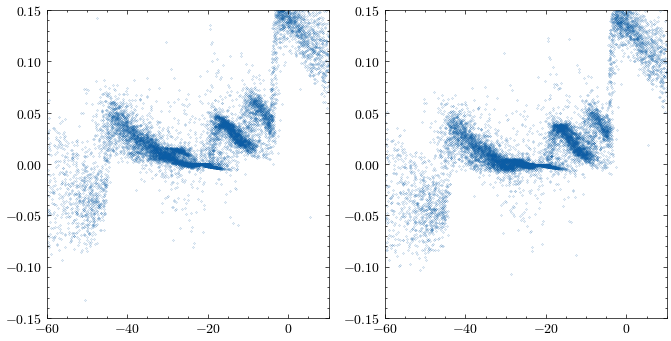

In [43]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
ax[0].scatter(phi1_unpert,delta_stream_lin[:,1],s=.02)


ax[1].scatter(phi1_smooth,delta_stream_nonlin[:,1],s=.02)

for i in range(2):
    ax[i].set_xlim(-60,10)
    
    ax[i].set_ylim(-.15,.15)

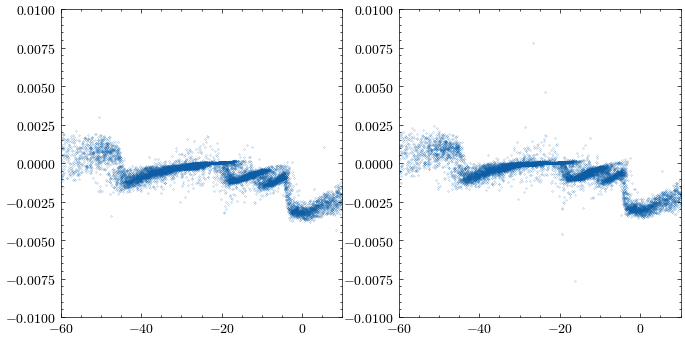

In [55]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
ax[0].scatter(phi1_unpert,delta_stream_lin[:,3],s=.02)


ax[1].scatter(phi1_smooth,delta_stream_nonlin[:,3],s=.02)

for i in range(2):
    ax[i].set_xlim(-60,10)
    
    ax[i].set_ylim(-.01,.01)

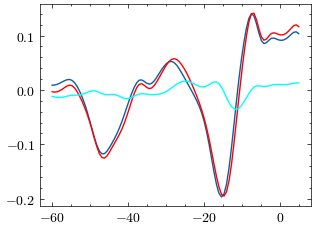

In [46]:
kde_smooth = gaussian_kde(phi1_smooth,bw_method=0.1)
kde_lin_pert = gaussian_kde(phi1_lin,bw_method=0.1)
kde_nonlin_pert = gaussian_kde(phi1_nonlin,bw_method=0.1)

phi1_eval = jnp.linspace(-60,5,100)

unpert_eval = kde_smooth.pdf(phi1_eval)
pert_eval_lin = kde_lin_pert.pdf(phi1_eval) 
pert_eval_nonlin = kde_nonlin_pert.pdf(phi1_eval)

delta_contrast_lin = (pert_eval_lin-unpert_eval)/unpert_eval
delta_contrast_nonlin = (pert_eval_nonlin-unpert_eval)/unpert_eval

plt.plot(phi1_eval,delta_contrast_nonlin)
plt.plot(phi1_eval,delta_contrast_lin,color='r')
plt.plot(phi1_eval,delta_contrast_lin-delta_contrast_nonlin,color='cyan')

#plt.ylim(-.1,.1)